<a href="https://colab.research.google.com/github/Amenhotep19/0x/blob/master/Copy_of_Copy_of_3_Fitting_Neural_Nets_to_MNIST_Handwritten_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __3: Fitting Neural Nets to MNIST Handwritten Digits__

## Learning Objectives

In this notebook, we'll learn...
- how to fit a neural network to flat data and best practices for preprocessing
- how to use callbacks and validation sets to stop training and prevent overfitting

## Import modules
As before, let's start by importing the necessary Python modules, including `tensorflow`, `numpy`, and `matplotlib`.

In [0]:
# Import latest TensorFlow 2 release, NumPy, and matplotlib
# Until 2.x is the default in Colab, stipulates that we want to load the latest version of TensorFlow 2.0, not 1.x.
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, ActivityRegularization, Input, Reshape, Flatten, Conv2D
from tensorflow.keras.utils import plot_model, to_categorical

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Changing this option from the default of 75 characters will allow arrays to print entire rows.
np.set_printoptions(linewidth=np.inf)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing MNIST data

For this part of the workshop we'll use the MNIST handwriting data set. You might've heard of this dataset -- it's a benchmark for machine learning techniques and is easily accessible through Tensorflow.

The dataset contains $60,000$ examples for training and $10,000$ examples for testing. Each image is $28\times 28$ pixels, each with a greyscale value from 0 to 255 (0 is black, 255 is white). Below, see some examples; for more on MNIST, see Yann LeCun's [website](http://yann.lecun.com/exdb/mnist/). 

<br>
<img src="https://github.com/allemanau/NUIT_tensorflow/blob/master/images/mnist.jpg?raw=1">
<br><br>

### Data dimension
Here, we specify the dimensions of the images which will be used in several places in the code below. Defining these variables makes it easier (compared with using hard-coded number all throughout the code) to modify them later. Ideally these would be inferred from the data that has been read, but here we will just write the numbers.

It's important to note that in a linear model, we have to flatten the input images into a vector. Here, each of the $28\times28$ images are flattened into a vector of length 784. 

### 1.3. Load the data and display the sizes
Because it is so often used to test network architecture, built-in functions are provided to load the data set into TensorFlow. We can use a built-in function to load the `train` and `test` splits easily:

In [0]:
# Load MNIST data
mnist = tf.keras.datasets.mnist
(x_train, raw_y_train), (x_test, raw_y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


To get a better sense of the data, let's check out the shapes of the loaded arrays.

In [0]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(raw_y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(raw_y_test.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


Let's take a look at a raw training example.

In [0]:
# Enables the console to print entire rows of the array.
print("{}".format(x_train[2020]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 167 208  19   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  13 235 254  99   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  74 254 234   4   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 154 254 145   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 224 254  92   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  51 245 211  13   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2 169 254 101   0   0   0   0   0   

Although there are model configurations that don't require __one-hot encoding__ of the outcome variable, it's good practice to stick with a consistent coding scheme unless you are comfortable with optimization options. One-hot encoding just changes the representation from a single categorical variable to a categorical indicator matrix. Although we don't have a model built yet, let's do this now.

In [0]:
# One hot encode classes
y_train = to_categorical(raw_y_train, num_classes = 10)
y_test = to_categorical(raw_y_test, num_classes = 10)

print("First three entries of raw y_train:\n {}\n".format(raw_y_train[0:3]))
print("First three rows of one-hot y_train:\n {}".format(y_train[0:3,]))

First three entries of raw y_train:
 [5 0 4]

First three rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


### Plot a few examples

Let's take a quick look at a sample of the handwritten digits in the data.

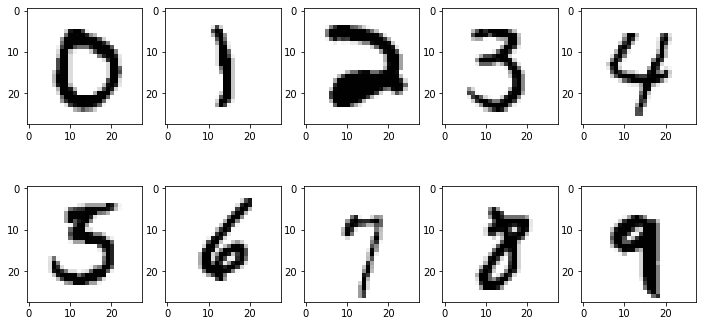

In [0]:
fig = plt.figure(figsize = (12, 6))

for i in range(10):
    ind = np.random.choice(np.ndarray.flatten(np.argwhere(raw_y_train == i)))
    plottable_image = np.reshape(x_train[ind], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')

## __Hyperparameters__

In the last notebook, we talked a bit about specifying the number of epochs to train for -- nothing formal, just recognition of the fact that 500 epochs was too many. In reality, this is just one of many hyperparameters we can tune to improve performance and convergence, or reduce training time and memory usage.

- _Length of model fitting routine_
  - __epoch__: one forward pass and one backward pass of __all__ the training examples, regulated by the `epochs` parameter. (Each progress bar you see in the output of `fit()`)
  - __batch size__: the number of training examples in one forward/backward pass, regulated by the `batch_size` parameter. The higher the batch size, the more memory space you'll need, and the less often the model's parameters will update.
  - __iteration__: one forward pass and one backward pass of __one batch of images__ the training examples. The number of iterations in one epoch is related to the batch size and number of training examples as 

  \begin{equation*}
  \text{iterations} = \text{ceiling}(\text{training examples}/\text{batch size})
  \end{equation*}

- _Rate of model weight adjustment_
  - __learning rate__: controls the rate at which model parameters are adjusted, regulated by the `learning_rate` parameter. Lower rates mean the model trains slower, but with potentially improved convergence. Higher rates mean faster training but can cause convergence issues.
  - __optimizer__: some optimizers are better for certain applications. Some are just better than others, period.

In [0]:
# Global settings
loss_fn = 'categorical_crossentropy'
optim = 'adam'
batch_size = 500

### Specify a network architecture

Below is the neural network architecture we will use today for classifying MNIST digits.

<img src="https://github.com/allemanau/NUIT_tensorflow/blob/master/images/network_architecture.png?raw=1">

Using the layering syntax from the previous notebook, let's build this model.

## __Exercise__

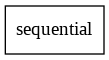

In [0]:
### BUILD THE MODEL BELOW
basic_model = Sequential()

# Add layers here.


# Plot our model.
plot_model(basic_model, show_shapes = True)

## Compile and fit the model

The model's architecture is specified and has been instantiated as an object. Now, we need to __compile__ and __fit__ the model to data. Along the way, there are still several choices to make: which method should be used to optimize the network, by what loss function will we measure our success, and which progress metrics should be reported?

In [0]:
# In general, the ADAM optimizer does a good job. For larger data sets, 
# stochastic gradient descent can be a better choice.
basic_model.compile(optimizer = optim,
                    loss = loss_fn,
                    metrics = ['accuracy'])

history = basic_model.fit(x_train, 
                y_train, 
                batch_size = batch_size,
                epochs = 10)

Epoch 1/10


ValueError: ignored

Evaluation on the test set indicates the model is about 95% accurate -- not bad for a first pass on a balanced multi-class prediction problem with only 10 epochs of training.

In [0]:
score = basic_model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy:")
print("{}%".format(np.round(100*score[1], 2)))

ValueError: ignored

Let's look at a few misclassified examples. Although there'll be variation due to the random selection of examples, there's a mixed bag of understandable confusion and bad misses here.

[[ 0  0  0 ... 11 11  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 11  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0 19 ...  0  0  0]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


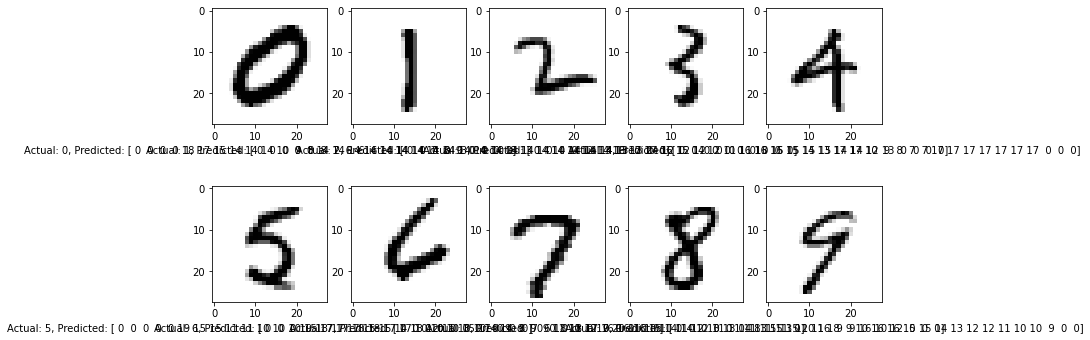

In [0]:
# Get predicted classes.
preds = basic_model.predict_classes(x_test)
print(preds)

# Prepare a figure for subplotting.
fig = plt.figure(figsize=(12, 6))

# Select one random misclass for each digit in the data set.
for i in range(10):
    ind = np.random.choice(np.ndarray.flatten(np.argwhere((raw_y_test == i) & (raw_y_test != preds))))
    actual = raw_y_test[ind]
    predicted = preds[ind]
    plottable_image = np.reshape(x_test[ind], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')
    plt.xlabel("Actual: " + "{}".format(actual) + ", Predicted: " + "{}".format(predicted))

### Importance of scaling features

Unscaled features can result in numerical instability in the gradient during the fitting process, slowing convergence and drgrading performance. Let's rescale the features to lie between 0 and 1 and refit the model.

In [0]:
# General rescaling: (x - min(x))/(max(x) - min(x))
# In this dataset, grayscale values lie between 0 and 255. 
# Thus, rescaling is easy:
x_train_scl = x_train / 255.0
x_test_scl = x_test / 255.0

scaled_model = Sequential()
scaled_model.add(Flatten(input_shape = (28,28)))
scaled_model.add(Dense(units = 128))
scaled_model.add(Activation(activation = 'relu'))
scaled_model.add(Dense(units = 10))
scaled_model.add(Activation(activation = 'softmax'))

scaled_model.compile(optimizer = 'adam',
              loss = loss_fn,
              metrics = ['accuracy'])

history = scaled_model.fit(x_train_scl, 
          y_train, 
          batch_size = batch_size,
          epochs=10)

Epoch 1/10
120/120 [==============================] - 1s 9ms/step - loss: 0.5649 - accuracy: 0.8464
Epoch 2/10
120/120 [==============================] - 1s 8ms/step - loss: 0.2474 - accuracy: 0.9306
Epoch 3/10
120/120 [==============================] - 1s 8ms/step - loss: 0.1907 - accuracy: 0.9466
Epoch 4/10
120/120 [==============================] - 1s 8ms/step - loss: 0.1559 - accuracy: 0.9561
Epoch 5/10
120/120 [==============================] - 1s 8ms/step - loss: 0.1321 - accuracy: 0.9624
Epoch 6/10
120/120 [==============================] - 1s 8ms/step - loss: 0.1126 - accuracy: 0.9687
Epoch 7/10
120/120 [==============================] - 1s 9ms/step - loss: 0.0994 - accuracy: 0.9726
Epoch 8/10
120/120 [==============================] - 1s 8ms/step - loss: 0.0885 - accuracy: 0.9753
Epoch 9/10
120/120 [==============================] - 1s 8ms/step - loss: 0.0792 - accuracy: 0.9774
Epoch 10/10
120/120 [==============================] - 1s 8ms/step - loss: 0.0710 - accuracy: 0.9801

First thing to note: the model converged much faster. The training accuracy by the second or third epoch beats the model trained on unscaled data after 10 epochs.

The second important thing to note is that the accuracy against the training data is obviously much higher, although we should be careful using this metric because it doesn't generalize meaningfully. Evaluating the model against rescaled test data demonstrates this improvement translates to unseen examples:

In [0]:
score = scaled_model.evaluate(x_test_scl, y_test, verbose=0)
print("Test accuracy:")
print("{}%".format(np.round(100*score[1], 2)))

Test accuracy:
97.29%


Taking a peek at misclasses:

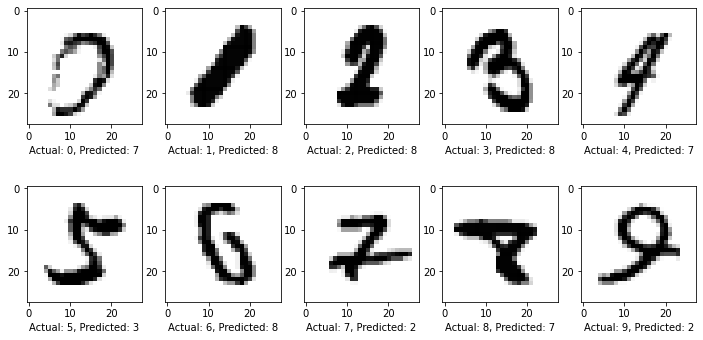

In [0]:
# Get predicted classes.
preds = scaled_model.predict_classes(x_test)

# Prepare a figure for subplotting.
fig = plt.figure(figsize=(12, 6))

# Select one random misclass for each digit in the data set.
for i in range(10):
    ind = np.random.choice(np.ndarray.flatten(np.argwhere((raw_y_test == i) & (raw_y_test != preds))))
    actual = raw_y_test[ind]
    predicted = preds[ind]
    plottable_image = np.reshape(x_test[ind], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')
    plt.xlabel("Actual: " + "{}".format(actual) + ", Predicted: " + "{}".format(predicted))

## __Measuring progress using a validation set__

In recognition of the fact that overfitting, that most insidious foe of deep neural networks, can easily happen on complicated problems like this, consider for a moment that we can generally improve training accuracy by increasing the number of epochs. So how do we choose when to stop?


This is a job for a validation data set. Holding a small (5-10%) sample of our training data out of the training process enables us to test the out-of-sample accuracy of the model at each epoch. The idea here is to stop training the model when the validation metric starts moving the opposite direction of the training metric. In the case of accuracy, this would mean the training process should stop when the validation accuracy starts decreasing, and vice versa in the case of validation loss.


#### Model callbacks

In Tensorflow, a __callback__ is a utility called during the training process. They have various purposes, from logging histories to halting the fitting process (see the Tensorflow docs for a [full list of callback options](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)). One useful callback forces the training process to stop early if a validation metric isn't improving, which we'll use here.


In [0]:
valid_model = Sequential()
valid_model.add(Flatten(input_shape=(28, 28)))
valid_model.add(Dense(128))
valid_model.add(Activation(activation = 'relu'))
valid_model.add(Dense(10))
valid_model.add(Activation(activation = 'softmax'))

valid_model.compile(optimizer = optim,
              loss = loss_fn,
              metrics = ['accuracy'])

# Use a callback to stop the model training once "patience" epochs have passed
# without improvement in the validation accuracy. In addition, request
# that the weights from the best iteration are restored.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            patience=10,
                                            restore_best_weights = True)

# Add our callback to the model. Several callbacks could be specified
# in a single list!
history = valid_model.fit(x_train_scl, 
          y_train, 
          batch_size = batch_size,
          epochs = 50,
          validation_split = 0.1,
          callbacks = [callback])

Epoch 1/50
108/108 [==============================] - 1s 12ms/step - loss: 0.6106 - accuracy: 0.8399 - val_loss: 0.2501 - val_accuracy: 0.9298
Epoch 2/50
108/108 [==============================] - 1s 11ms/step - loss: 0.2659 - accuracy: 0.9258 - val_loss: 0.1866 - val_accuracy: 0.9525
Epoch 3/50
108/108 [==============================] - 1s 10ms/step - loss: 0.2059 - accuracy: 0.9423 - val_loss: 0.1534 - val_accuracy: 0.9620
Epoch 4/50
108/108 [==============================] - 1s 10ms/step - loss: 0.1686 - accuracy: 0.9527 - val_loss: 0.1294 - val_accuracy: 0.9663
Epoch 5/50
108/108 [==============================] - 1s 10ms/step - loss: 0.1430 - accuracy: 0.9597 - val_loss: 0.1169 - val_accuracy: 0.9687
Epoch 6/50
108/108 [==============================] - 1s 10ms/step - loss: 0.1244 - accuracy: 0.9651 - val_loss: 0.1059 - val_accuracy: 0.9703
Epoch 7/50
108/108 [==============================] - 1s 10ms/step - loss: 0.1090 - accuracy: 0.9696 - val_loss: 0.1004 - val_accuracy: 0.9737

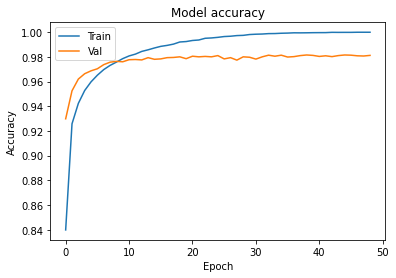

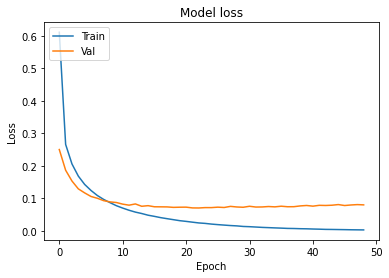

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

As before, we evaluate our model and should discover marginal improvement using early stopping. Depending on the random components of the fitting process, you may be unlucky enough to see no improvement. (In this case, imagine if we had instead trained the model for 100 epochs, or 500 epochs. Alternatively, check with your neighbors and see whether they experienced improvement.)

In [0]:
score = valid_model.evaluate(x_test_scl, y_test, verbose=0)
print("Test accuracy:")
print("{}%".format(np.round(100*score[1], 2)))

Test accuracy:
97.91%


## __Dropout__

In spite of our efforts to control overfitting with a validation set, we're hitting perfect classification accuracy on the training data, which suggests overfitting. Let's try to use a `Dropout` layer to fix this small problem.

In [0]:
dropout_model = Sequential()
dropout_model.add(Flatten(input_shape = (28, 28)))
dropout_model.add(Dense(128))
dropout_model.add(Activation(activation = 'relu'))
dropout_model.add(Dropout(rate = 0.2))
dropout_model.add(Dense(10))
dropout_model.add(Activation(activation = 'softmax'))

dropout_model.compile(optimizer = optim,
              loss = loss_fn,
              metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            patience = 10,
                                            restore_best_weights = True)

history = dropout_model.fit(x_train_scl, 
          y_train, 
          batch_size = batch_size,
          epochs = 50,
          validation_split = 0.1,
          callbacks = [callback])

Epoch 1/50
108/108 [==============================] - 1s 12ms/step - loss: 0.6689 - accuracy: 0.8089 - val_loss: 0.2538 - val_accuracy: 0.9327
Epoch 2/50
108/108 [==============================] - 1s 11ms/step - loss: 0.3010 - accuracy: 0.9141 - val_loss: 0.1894 - val_accuracy: 0.9485
Epoch 3/50
108/108 [==============================] - 1s 11ms/step - loss: 0.2358 - accuracy: 0.9329 - val_loss: 0.1580 - val_accuracy: 0.9570
Epoch 4/50
108/108 [==============================] - 1s 12ms/step - loss: 0.1983 - accuracy: 0.9426 - val_loss: 0.1326 - val_accuracy: 0.9643
Epoch 5/50
108/108 [==============================] - 1s 11ms/step - loss: 0.1713 - accuracy: 0.9508 - val_loss: 0.1225 - val_accuracy: 0.9660
Epoch 6/50
108/108 [==============================] - 1s 11ms/step - loss: 0.1524 - accuracy: 0.9568 - val_loss: 0.1086 - val_accuracy: 0.9702
Epoch 7/50
108/108 [==============================] - 1s 11ms/step - loss: 0.1348 - accuracy: 0.9615 - val_loss: 0.0985 - val_accuracy: 0.9725

Evaluating accuracy on the test set, most of you should see a small improvement:

In [0]:
score = dropout_model.evaluate(x_test_scl, y_test, verbose=0)
print("Test accuracy:")
print("{}%".format(np.round(100*score[1], 2)))

Test accuracy:
97.9%


## __Summarizing incremental improvements__

Even if you didn't see the improvements in specific cases, maybe a small statistical anecdote will convince you of the incremental improvements we made. Each of the nets we fit above were refit 10 times for 50 epochs or whenever the stopping criterion was met, and the test accuracy is reported using boxplots below.

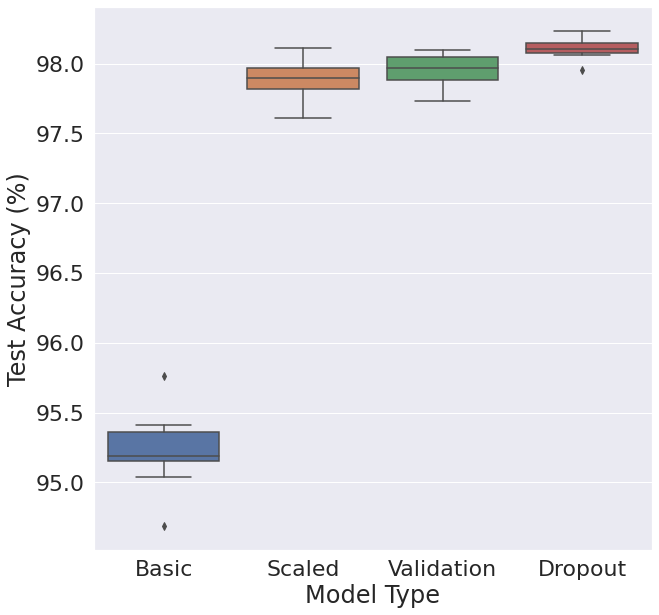

In [0]:
# Experimental results, 10 fits each, 50 epochs or whenever a callback stops training.
basic = [95.19, 95.35, 95.76, 95.15, 94.69, 95.18, 95.36, 95.04, 95.41, 95.17]
scale = [97.75, 98.07, 97.61, 97.93, 97.84, 97.93, 97.81, 97.86, 98.11, 97.98]
valid = [97.89, 97.98, 97.88, 97.87, 98.05, 98.10, 97.96, 97.73, 98.05, 98.06]
dropout = [98.06, 98.12, 98.15, 97.95, 98.15, 98.18, 98.09, 98.08, 98.07, 98.23]

# Construct pandas DataFrame from results.
df = pd.DataFrame({'Model Type' : ["Basic"]*10 + ["Scaled"]*10 + ["Validation"]*10 + ["Dropout"]*10,
        'Test Accuracy (%)' : basic + scale + valid + dropout})
df['Model Type'] = df['Model Type'].astype(pd.api.types.CategoricalDtype(categories = ["Basic", "Scaled", "Validation", "Dropout"], ordered=True))

# Draw boxplots of test performance by model type.
sns.set(font_scale = 2)
fig = plt.figure(figsize=(10, 10))
sns.boxplot(x = df['Model Type'], y = df['Test Accuracy (%)'], )

## __Exercise: can you improve on the dropout model?__ (~10 min)

Can you improve on the dropout model using only the layer types we've used so far? Keep track of your best test accuracy and the changes you made to get it. We'll reconvene to see who was able to do the best.

__Tips__: try making the network more complex. Add a layer or two and/or increase the number of hidden nodes. Remember that complexity can lead to overfitting, so make use of dropout!

In [0]:
ex_model = Sequential()
ex_model.add(Flatten(input_shape=(28, 28)))
ex_model.add(Dense(128))
ex_model.add(Activation(activation = 'relu'))
ex_model.add(Dropout(rate = 0.2))
ex_model.add(Dense(10))
ex_model.add(Activation(activation = 'softmax'))

ex_model.compile(optimizer = optim,
              loss = loss_fn,
              metrics = ['accuracy'])

# Use a callback to stop the model training once "patience" epochs have passed
# without improvement in the validation accuracy. In addition, request
# that the weights from the best iteration are restored.
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                            patience = 10,
                                            restore_best_weights = True)

# Add our callback to the model. Several callbacks could be specified
# in a single list!
history = ex_model.fit(x_train_scl, 
          y_train, 
          batch_size = batch_size,
          epochs = 50,
          validation_split = 0.1,
          callbacks = [callback])

score = ex_model.evaluate(x_test_scl, y_test, verbose=0)
print("Test accuracy:")
print("{}%".format(np.round(100*score[1], 2)))

Epoch 1/50
108/108 [==============================] - 1s 13ms/step - loss: 0.6628 - accuracy: 0.8113 - val_loss: 0.2555 - val_accuracy: 0.9353
Epoch 2/50
108/108 [==============================] - 1s 12ms/step - loss: 0.3026 - accuracy: 0.9138 - val_loss: 0.1894 - val_accuracy: 0.9525
Epoch 3/50
108/108 [==============================] - 1s 12ms/step - loss: 0.2392 - accuracy: 0.9319 - val_loss: 0.1553 - val_accuracy: 0.9597
Epoch 4/50
108/108 [==============================] - 1s 12ms/step - loss: 0.1986 - accuracy: 0.9438 - val_loss: 0.1325 - val_accuracy: 0.9645
Epoch 5/50
108/108 [==============================] - 1s 12ms/step - loss: 0.1739 - accuracy: 0.9514 - val_loss: 0.1186 - val_accuracy: 0.9677
Epoch 6/50
108/108 [==============================] - 1s 12ms/step - loss: 0.1544 - accuracy: 0.9557 - val_loss: 0.1100 - val_accuracy: 0.9703
Epoch 7/50
108/108 [==============================] - 1s 11ms/step - loss: 0.1373 - accuracy: 0.9599 - val_loss: 0.0990 - val_accuracy: 0.9717

## __Review__

Concepts to know:

- __Network architecture__
  - Expressing a model in TensorFlow using a network diagram
- __Best practices__
  - Feature scaling (can also normalize)
  - One-hot encoding
- __Validation splits__
  - Using callbacks to stop model training early
- __Dropout__
  - What is the purpose of this layer?
  - How does it work?

## __Next__: boosting accuracy via convolutional layers.